In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate, dot, maximum, Attention, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate,BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dropout
import tqdm
import random
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.regularizers import l2
from keras import backend as K
import keras
import os

2023-03-05 19:49:36.304318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataset_df = pd.read_csv("dataset.csv")

In [3]:
dataset_df.head()

,Sample ID,Cancer Type,Mutation Count,Sex,Sample Type,DNA Input,Matched Status,Oncotree Code,Overall Survival Status,Patient's Vital Status,...,VHL,VTCN1,WT1,XIAP,XPO1,XRCC2,YAP1,YES1,ZFHX3,ZRSR2
0,P-0000036-T01-IM3,Non-Small Cell Lung Cancer,3,Female,Primary,50.0,Unmatched,LUAD,0:LIVING,ALIVE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,P-0000047-T01-IM3,Mesothelioma,2,Male,Primary,250.0,Matched,PLEMESO,1:DECEASED,DECEASED,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,P-0000058-T01-IM3,Breast Cancer,1,Female,Metastasis,144.0,Matched,IDC,0:LIVING,ALIVE,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,P-0000068-T01-IM3,Bladder Cancer,4,Male,Primary,250.0,Matched,BLCA,1:DECEASED,DECEASED,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,P-0000187-T01-IM3,Breast Cancer,6,Female,Metastasis,250.0,Matched,BRCANOS,1:DECEASED,DECEASED,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
grouped = dataset_df.groupby('Cancer Type').filter(lambda x: len(x) >= 30)
dataset_df = dataset_df[dataset_df['Cancer Type'].isin(grouped['Cancer Type'].unique())]

In [5]:
category_counts = dataset_df.groupby('Cancer Type').size().reset_index(name='counts')

In [6]:
category_counts

,Cancer Type,counts
0,Bladder Cancer,42
1,Bone Cancer,54
2,Breast Cancer,242
3,Cancer of Unknown Primary,43
4,Colorectal Cancer,100
5,Endometrial Cancer,32
6,Esophagogastric Cancer,63
7,Glioma,158
8,Head and Neck Cancer,35
9,Hepatobiliary Cancer,70


In [7]:
constant_columns = [col for col in dataset_df.columns if dataset_df[col].nunique() == 1]
dataset_df = dataset_df.drop(columns=constant_columns)

In [8]:
dataset_df= dataset_df.dropna()
dataset_df = dataset_df.reset_index(drop=True)

In [9]:
classes = pd.unique(dataset_df["Cancer Type"])
n_classes = len(pd.unique(classes))
del dataset_df["Sample ID"]

In [10]:
le = LabelBinarizer()

In [11]:
y_df = dataset_df["Cancer Type"]
y_df.head()
del dataset_df["Cancer Type"]

In [12]:
y = y_df.to_numpy()

In [13]:
object_cols = list(dataset_df.select_dtypes(include='object'))
other_cols = list(dataset_df.select_dtypes(exclude='object'))
ohe_encoded_data = pd.get_dummies(dataset_df, columns=object_cols,drop_first=False)
encoded_data = pd.concat([ohe_encoded_data,dataset_df[other_cols]],axis=1)

In [14]:
encoded_data.to_csv("encoded-dataset.csv",index=False)

In [15]:
d = preprocessing.normalize(encoded_data)
scaled_df = pd.DataFrame(d)

In [16]:
pca = PCA()
df_merged_pca = pca.fit_transform(scaled_df)

In [17]:
np.array(scaled_df).shape

(1754, 2138)

In [18]:
from sklearn.feature_selection import f_classif
scores =  (df_merged_pca, y_df.to_numpy())

In [19]:
from itertools import permutations

In [20]:
x_train,x_test,y_train,y_test = train_test_split(np.array(df_merged_pca),y)

In [21]:
y_train_ohe =  le.fit_transform(y_train)

In [22]:
inputs= Input(x_train[0].shape)

In [23]:
input_shape= x_train[0].shape

input1 = Input(input_shape)

In [24]:
def create_support_set(x_train,y_train,classes,n):
    x_support = []
    y_support = []
    for c in classes:
        indices = np.where(y_train == c)
        for i in range(0,n):
            x_support.append(x_train[indices[0][i]])
            y_support.append(y_train[indices[0][i]])
    return np.array(x_support),np.array(y_support)

In [25]:
x_support,y_support = create_support_set(x_train,y_train,classes,2)

In [26]:
input_layer = Dense(1754,activation ='relu',input_shape=x_train[0].shape)(input1)

hidden_layers = Dense(750,activation='relu')(input_layer)
hidden_layers = BatchNormalization()(hidden_layers)
hidden_layers = Dense(750,activation='relu')(hidden_layers)
hidden_layers = BatchNormalization()(hidden_layers)
hidden_layers = Dense(750,activation='relu')(hidden_layers)
hidden_layers = BatchNormalization()(hidden_layers)
hidden_layers = Dense(750,activation='relu')(hidden_layers)
hidden_layers = BatchNormalization()(hidden_layers)
hidden_layers = Dense(750,activation='relu')(hidden_layers)
hidden_layers = BatchNormalization()(hidden_layers)
hidden_layers = Dropout(0.1)(hidden_layers)
classifier= Dense(n_classes,activation ='softmax')(hidden_layers)

model = Model(inputs=input_layer, outputs=classifier)
model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=["accuracy",tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])

2023-03-05 19:49:50.632212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-05 19:49:50.654717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-05 19:49:50.656706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-05 19:49:50.658925: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow w

In [27]:
history=model.fit(x_train,y_train_ohe,batch_size=64,epochs=100,validation_split=0.2)

Epoch 1/100


2023-03-05 19:49:53.037408: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-05 19:49:53.040337: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55a528e49950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-05 19:49:53.040352: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-03-05 19:49:53.044637: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-05 19:49:53.044917: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-03-05 19:49:53.110802: I tensorflow/tsl/platform/default/subprocess.cc:304] 

17/17 [==============================] - 4s 27ms/step - loss: 3.1586 - accuracy: 0.2006 - precision: 0.3600 - recall: 0.0941 - auc: 0.6327 - val_loss: 2.6573 - val_accuracy: 0.1977 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6837
Epoch 2/100
17/17 [==============================] - 0s 6ms/step - loss: 2.1200 - accuracy: 0.3935 - precision: 0.7209 - recall: 0.2063 - auc: 0.8090 - val_loss: 2.6330 - val_accuracy: 0.1977 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6527
Epoch 3/100
17/17 [==============================] - 0s 6ms/step - loss: 1.5678 - accuracy: 0.5542 - precision: 0.7810 - recall: 0.4306 - auc: 0.9017 - val_loss: 2.6864 - val_accuracy: 0.1977 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5826
Epoch 4/100
17/17 [==============================] - 0s 6ms/step - loss: 1.1444 - accuracy: 0.6616 - precision: 0.8731 - recall: 0.5561 - auc: 0.9468 - val_loss: 2.7141 - val_accuracy: 0.1977 - val_precision: 0.0000e+00 - 

In [28]:
y_test_ohe = le.fit_transform(y_test)

In [29]:
def eval_dnn(x_test,y_test,y_test_ohe,classes,model):
    results = pd.DataFrame(columns=["Cancer","Loss","Accuracy","Precision","Recall","AUC","F1 Score"])
    for cancer in classes:
        indices = np.where(y_test==cancer)
        x_test_eval = x_test[indices]
        y_test_eval = y_test_ohe[indices]
        (loss, accuracy, precision, recall,auc) = model.evaluate(x_test_eval,y_test_eval)
        f1_score = 2*((precision*recall)/(precision+recall+K.epsilon()))
        new_row = {"Cancer": cancer, "Loss": loss, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "AUC": auc, "F1 Score": f1_score}
        results = pd.concat([results,pd.DataFrame.from_dict([new_row])])
    return results

In [30]:
model.evaluate(x_test,y_test_ohe)

14/14 [==============================] - 0s 2ms/step - loss: 0.5457 - accuracy: 0.8975 - precision: 0.9196 - recall: 0.8861 - auc: 0.9744


[0.5457448959350586,
 0.8974943161010742,
 0.9196217656135559,
 0.8861047625541687,
 0.97438645362854]

In [31]:
dnn_results = eval_dnn(x_test,y_test,y_test_ohe,classes,model)

1/1 [==============================] - 0s 22ms/step - loss: 0.4458 - accuracy: 0.8571 - precision: 0.8500 - recall: 0.8095 - auc: 0.9947


In [32]:
dnn_results

,Cancer,Loss,Accuracy,Precision,Recall,AUC,F1 Score
0,Non-Small Cell Lung Cancer,0.222917,0.962963,0.962500,0.950617,0.993014,0.956522
0,Breast Cancer,0.403626,0.931035,0.929825,0.913793,0.972661,0.921739
0,Bladder Cancer,0.907647,0.833333,1.000000,0.750000,0.945833,0.857143
0,Head and Neck Cancer,3.557362,0.500000,0.555556,0.500000,0.747333,0.526316
0,Bone Cancer,0.874127,0.785714,0.846154,0.785714,0.957313,0.814815
0,Soft Tissue Sarcoma,2.417866,0.629630,0.680000,0.629630,0.866530,0.653846
0,Prostate Cancer,0.011922,1.000000,1.000000,1.000000,1.000000,1.000000
0,Ovarian Cancer,2.306796,0.375000,0.500000,0.375000,0.852083,0.428571
0,Glioma,0.017366,1.000000,1.000000,1.000000,1.000000,1.000000
0,Esophagogastric Cancer,1.004104,0.833333,0.833333,0.833333,0.954398,0.833333


In [33]:
inputs1 = Input(1754)
inputs2 = Input(1754)

In [34]:
def create_couples(x_support,y_support,x_train,y_train):
    x_train_left = []
    x_train_right = []
    y_train_set = []
    for i in range(0,len(x_support)):
        for j in range(0,len(x_train)):
            x_train_left.append(x_support[i])
            x_train_right.append(x_train[j])
            if(y_support[i] == y_train[j]):
                y_train_set.append(1)
            else:
                y_train_set.append(0)
                    
    return np.array(x_train_left),np.array(x_train_right),np.array(y_train_set)

In [35]:
x_train_left,x_train_right,y_train_set = create_couples(x_support,y_support,x_train,y_train)

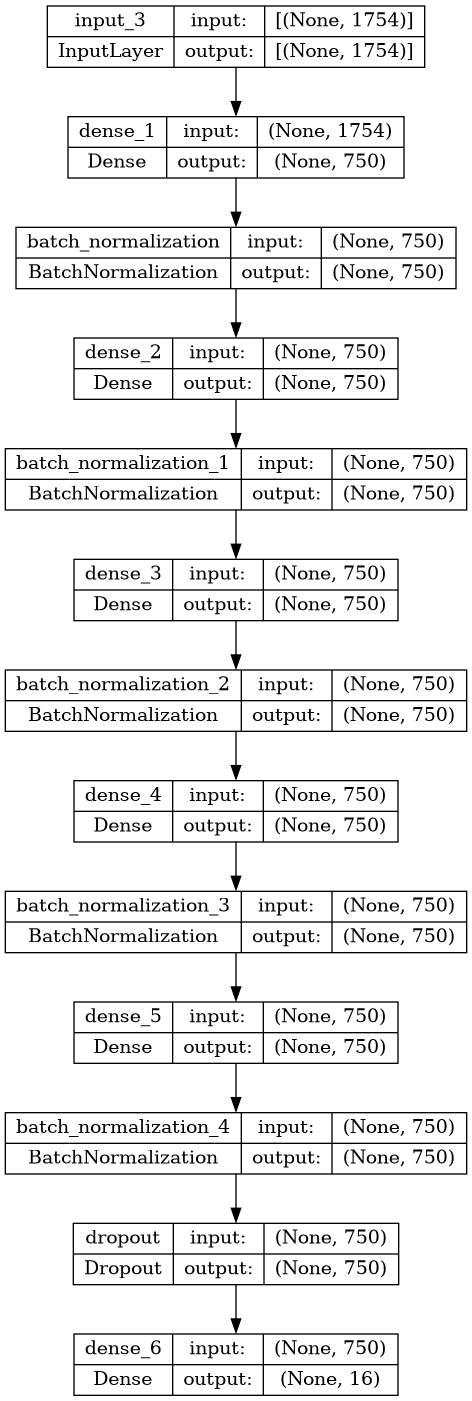

In [36]:
keras.utils.plot_model(model,"dnn-model.png",show_shapes=True)

In [37]:
left_model= Sequential(model.layers[:-1])

In [38]:
right_model = Sequential(model.layers[:-1])

In [39]:
for layer in left_model.layers:
    layer.trainable = False
for layer in right_model.layers:
    layer.trainable = False

In [40]:
left_input = Input(shape=input_shape, name='left_input')
right_input = Input(shape=input_shape, name='right_input')

left_output = left_model(left_input)
right_output = right_model(right_input)

merged_output = Lambda(lambda x: K.sqrt(K.sum(K.square(x[0] - x[1]), axis=1, keepdims=True))) ([left_output, right_output])

merged_output = Dense(320,activation = "relu")(merged_output)
merged_output = Dropout(0.1)(merged_output)
merged_output = BatchNormalization()(merged_output)
merged_output = Dense(320,activation = "relu")(merged_output)
merged_output = Dropout(0.1)(merged_output)
merged_output = BatchNormalization()(merged_output)
merged_output = Dense(320,activation = "relu")(merged_output)
merged_output = Dropout(0.1)(merged_output)
merged_output = BatchNormalization()(merged_output)

final_output = Dense(1, activation='sigmoid')(merged_output)

siamese_model = Model(inputs=[left_input, right_input], outputs=final_output)

siamese_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy",tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])


In [41]:
history_s = siamese_model.fit([x_train_left,x_train_right],y=y_train_set,batch_size=64, epochs=40,validation_split = 0.2)

Epoch 1/40
526/526 [==============================] - 5s 5ms/step - loss: 0.1765 - accuracy: 0.9483 - precision_1: 0.6268 - recall_1: 0.6760 - auc_1: 0.8795 - val_loss: 0.1298 - val_accuracy: 0.9541 - val_precision_1: 0.3553 - val_recall_1: 0.8147 - val_auc_1: 0.9554
Epoch 2/40
526/526 [==============================] - 2s 5ms/step - loss: 0.1206 - accuracy: 0.9685 - precision_1: 0.8744 - recall_1: 0.6505 - auc_1: 0.8959 - val_loss: 0.0631 - val_accuracy: 0.9843 - val_precision_1: 0.6953 - val_recall_1: 0.7672 - val_auc_1: 0.9581
Epoch 3/40
526/526 [==============================] - 2s 5ms/step - loss: 0.1195 - accuracy: 0.9683 - precision_1: 0.8762 - recall_1: 0.6464 - auc_1: 0.8973 - val_loss: 0.0717 - val_accuracy: 0.9791 - val_precision_1: 0.5909 - val_recall_1: 0.7845 - val_auc_1: 0.9578
Epoch 4/40
526/526 [==============================] - 2s 4ms/step - loss: 0.1194 - accuracy: 0.9682 - precision_1: 0.8751 - recall_1: 0.6455 - auc_1: 0.8980 - val_loss: 0.0896 - val_accuracy: 0.97

In [42]:
x_test_left,x_test_right,y_test_set = create_couples(x_support,y_support,x_test,y_test)

In [43]:
(loss, 
accuracy, precision, recall,auc) = siamese_model.evaluate([x_test_left,x_test_right],y_test_set)

439/439 [==============================] - 1s 2ms/step - loss: 0.1226 - accuracy: 0.9661 - precision_1: 0.8490 - recall_1: 0.5569 - auc_1: 0.8958


In [44]:
def which_cancer(x_support_set,y_support_set,sample,siamese_model):
    max = None
    cancer = None
    for i in range(0,len(x_support_set)):
        prediction = siamese_model.predict([x_support_set[i].reshape(1,-1),sample])
        if(max == None):
            max = prediction
            cancer = y_support_set[i]
        else:
            if(max< prediction):
                max = prediction
                cancer = y_support_set[i]
    return max,cancer

In [45]:
def eval_siamese_model(x_support,y_support,x_test,y_test,classes,siamese_model):
    results = pd.DataFrame(columns=["Cancer","Loss","Accuracy","Precision","Recall","AUC","F1 Score"])
    for cancer in classes:
        indices = np.where(y_test==cancer)
        x_test_eval = x_test[indices]
        y_test_eval = y_test[indices]
        x_test_left,x_test_right,y_test_set = create_couples(x_support,y_support,x_test_eval,y_test_eval)
        (loss, accuracy, precision, recall,auc) = siamese_model.evaluate([x_test_left,x_test_right],y_test_set)
        f1_score = 2*((precision*recall)/(precision+recall+K.epsilon()))
        new_row = {"Cancer": cancer, "Loss": loss, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "AUC": auc, "F1 Score": f1_score}
        results = pd.concat([results,pd.DataFrame.from_dict([new_row])])
    return results

In [46]:
results = eval_siamese_model(x_support,y_support,x_test,y_test,classes,siamese_model)

21/21 [==============================] - 0s 3ms/step - loss: 0.2749 - accuracy: 0.9360 - precision_1: 0.4000 - recall_1: 0.0476 - auc_1: 0.5324        


In [47]:
results

,Cancer,Loss,Accuracy,Precision,Recall,AUC,F1 Score
0,Non-Small Cell Lung Cancer,0.074384,0.982253,0.960317,0.746914,0.960181,0.840278
0,Breast Cancer,0.084038,0.973060,0.883721,0.655172,0.975840,0.752475
0,Bladder Cancer,0.129697,0.953125,0.687500,0.458333,0.925463,0.550000
0,Head and Neck Cancer,0.221959,0.943750,0.666667,0.200000,0.680583,0.307692
0,Bone Cancer,0.091722,0.973214,0.785714,0.785714,0.960162,0.785714
0,Soft Tissue Sarcoma,0.185826,0.945602,0.594595,0.407407,0.791427,0.483516
0,Prostate Cancer,0.101098,0.969122,0.967033,0.523810,0.960138,0.679537
0,Ovarian Cancer,0.227238,0.917969,0.368421,0.437500,0.786068,0.400000
0,Glioma,0.237458,0.943257,1.000000,0.092105,0.707768,0.168675
0,Esophagogastric Cancer,0.104480,0.973958,0.733333,0.916667,0.971123,0.814815


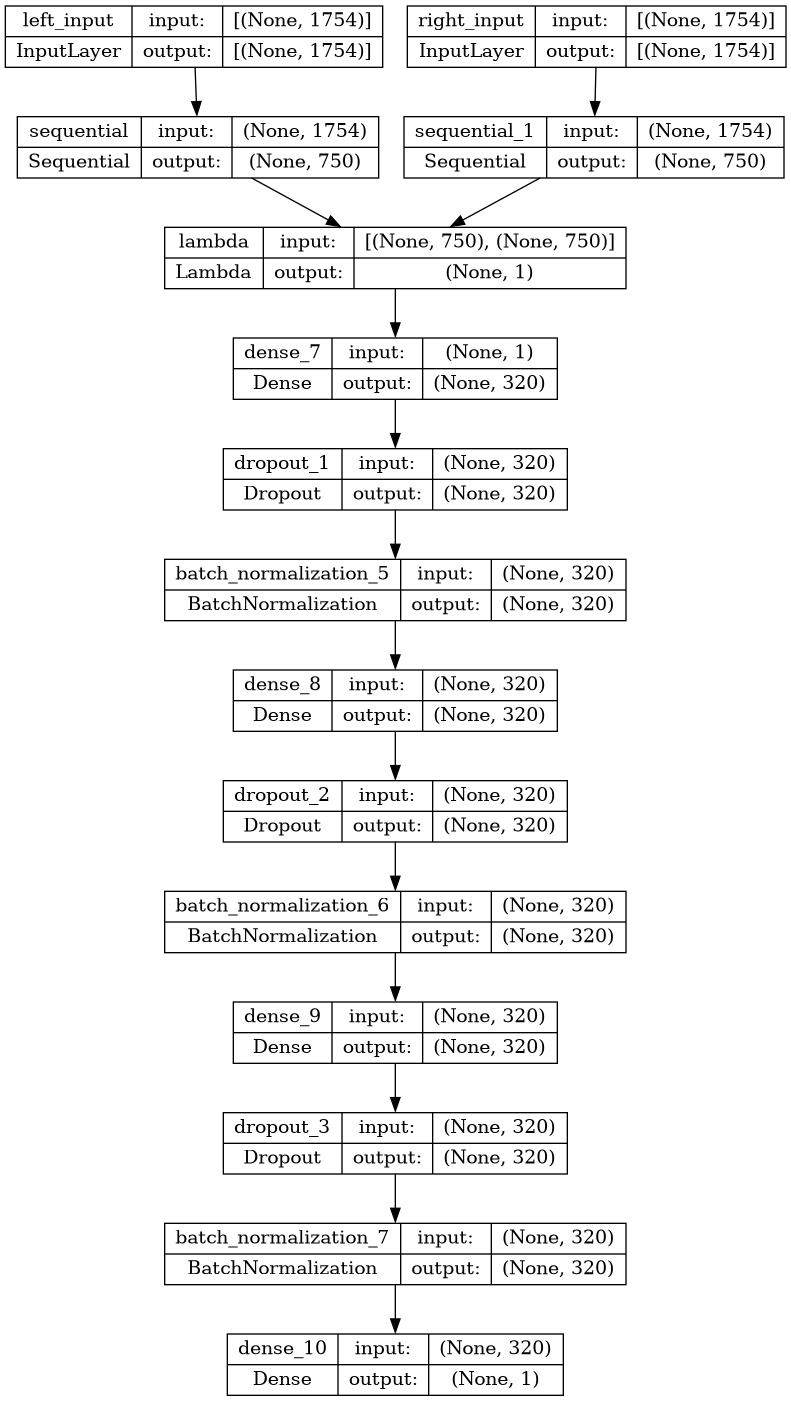

In [51]:
keras.utils.plot_model(siamese_model,"siamese-model.png",show_shapes=True)